In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
%matplotlib inline

matplotlib.rcParams.update({'font.size': 7, 'lines.linewidth': 0.7, 'figure.dpi': 300})

In [2]:
df = pd.read_json(r'./freq-user-data/data/binance/BTC_USDT-1m.json').dropna()
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

df['date'] = pd.to_datetime(df['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(df["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
df = df.sort_index()

In [3]:
# ddf.iloc[-100:]

In [5]:
# pd.Timestamp('now').floor('D') + pd.Timedelta(-7, unit='D')

# start_time = datetime(2021,5,1)

start_time = pd.Timestamp('now') + pd.Timedelta(-10, unit='W')
# start_time
ddf = df.loc[df.index >= start_time].copy()
# ddf = df.loc[df['time'] >= start_time]
# ddf

# ddf = ddf.resample('5Min').agg(
#     OrderedDict([
#         ('open', 'first'),
#         ('high', 'max'),
#         ('low', 'min'),
#         ('close', 'last'),
#         ('volume', 'sum'),
#     ])
# ).dropna()

# ema = ddf.close.ewm(span=50,min_periods=0,adjust=False,ignore_na=False).mean()
# detrended = ddf.close - ddf.ema

ddf['lret'] = ddf.close.apply(np.log).diff(1).fillna(0)
ddf['cumlret'] = ddf.lret.cumsum()

dlen = len(ddf.index)
dlen

99409

In [6]:
# buy_sig

Loaded 277480 rows of data for BTC/USDT from freq-user-data/data/binance


In [804]:
len(buy_sig_ind), len(sell_sig_ind)

(6, 6)

In [35]:
fee = 0.001

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,9)), step=1, value=1)
def update_sl_w_range(*args):
    wsize = pow(2,sl_n2.value)
    sl_w.max = floor(dlen/wsize) * 2 
sl_n2.observe(update_sl_w_range, 'value')

wdg_bb_ma = widgets.IntText(value=50,description='bbma:',disabled=False,continuous_update=False)
wdg_bb_stn = widgets.IntText(value=50,description='bbstn:',disabled=False,continuous_update=False)
wdg_bb_std = widgets.FloatText(value=3,step=0.2,description='bbstd:',disabled=False,continuous_update=False)


# wdg_dmper = widgets.IntText(value=14,description='dmper:',disabled=False,continuous_update=False)
# wdg_dmtr = widgets.IntText(value=-200,description='dmtr:',disabled=False,continuous_update=False)

wdg_rsiper = widgets.IntText(value=14,description='rsiper:',disabled=False,continuous_update=False)
wdg_rsitr = widgets.IntText(value=-200,description='rsitr:',disabled=False,continuous_update=False)

# wdg_krn = widgets.FloatText(value=1,step=0.25,description='krn:',disabled=False,continuous_update=False)
# wdg_krpow = widgets.FloatText(value=1, step=0.05,description='krpow:',disabled=False,continuous_update=False)
# wdg_krstart = widgets.FloatText(value=1, step=1/6.,description='krstrt:',disabled=False,continuous_update=False)
# wdg_krend = widgets.FloatText(value=2, step=1/6.,description='krend:',disabled=False,continuous_update=False)
# wdg_krflip = widgets.Checkbox(value=False,description='krflip:',disabled=False,continuous_update=False)
# wdg_krflipy = widgets.Checkbox(value=False,description='krflipy:',disabled=False,continuous_update=False)
# wdg_cnv = FloatRangeSlider(description="cnv", min=-1, step=0.005, max=1,value=[0,0.1],continuous_update=False)

wdg_stoploss = FloatText(description="sl", min=-0.05, step=0.001, max=0, value=-2)
wdg_takeprofit = FloatText(description="tp", min=0, step=0.001, max=0.1, value=0.02)


# slXrr = FloatSlider(description="xrr", min=1, step=0.2, max=20, value=2)

ui = widgets.VBox([
    widgets.HBox([sl_n2, sl_w, wdg_stoploss, wdg_takeprofit]),
    widgets.HBox([wdg_bb_ma, wdg_bb_stn, wdg_bb_std]),
    widgets.HBox([wdg_rsiper, wdg_rsitr])
    # widgets.HBox([wdg_dmper, wdg_dmtr])
    # widgets.HBox([wdg_krn, wdg_krstart, wdg_krend, wdg_krpow, wdg_krflip, wdg_krflipy, wdg_cnv])
    # widgets.HBox([slTrailingStopLoss, slStopLoss, slTakeProfit, slXrr]),
#     widgets.HBox([slStK, slStD, slStSm, slStT])
])


wst = wed = wsz = wdf = buy_sig = g_buy_sig_cum = buy_cond = False
sell_cond = sell_sig = buy_sig_ind = sell_sig_ind = False

position_groups = positions_start_row = positions_end_row =  positions_min_posret =  positions_max_posret = False
# , krn, krstart, krend, krpow, krflip, krflipy, cnv
# , dmper, dmtr
def printer(w2log, w, stoploss, takeprofit, bbma, bbstn, bbstd, rsiper, rsitr):

    global wst, wed, wsz, stoch, wdf, buy_cond, buy_sig, g_buy_sig_cum, sell_cond, sell_sig, buy_sig_ind, sell_sig_ind

    pars = {k: v.value for k, v in dvals.items()}
    with open(f'./strat-params-bbands-convol.json', "w") as f: f.write(json.dumps(pars)) 
    
    # krnn = floor(krn * 60)
    # krx = np.linspace(krstart, krend, krnn)
    # kry = krx

    # kry = np.tan(kry)
    # kry = np.sin(kry)
    # kry = np.power(kry , krpow)
    # if krflip: kry = np.flipud(kry)
    # if krflipy: kry = -(kry)
    # kry = kry - np.mean(kry)
    

    ddf['bb_middle'] = ddf.close.ewm(span=bbma,min_periods=0,adjust=False,ignore_na=False).mean()
    ddf['bb_std'] = ddf.close.rolling(bbstn).std()
    ddf['bb_std_bw'] = ddf.bb_std * bbstd
    ddf['bb_lower'] = ddf['bb_middle'] - ddf.bb_std_bw

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()

    rsidf = ta.rsi(wdf.close, length=rsiper, scalar=None, drift=None, offset=None)
    # dmdf = ta.dm(wdf.high, wdf.low, length=dmper, mamode=None, drift=None, offset=None)
    # dmdf.columns = ['dmp', 'dmn']
    # dmdf['dd'] = dmdf.dmp - dmdf.dmn

    # conv1 = wdf.cumlret.rolling(krnn).apply(lambda v: (v * kry).sum())
    # conv1 = wdf.cumlret.rolling(krnn).apply(lambda v: np.convolve(v , kry, mode='same')[-1])

    # ncut = floor(len(kry)/2)
    # conv1[:ncut] = 0
    # conv1[-ncut:] = 0
    # wdf['conv1'] = conv1
    
    wdf['exit_sig'] = False
    wdf['pos'] = 0
    wdf['poslret'] = 0
    wdf['poscumlret'] = 0
    wdf['postradecumlret'] = 0
    wdf['totcumlret'] = 0

    # position_groups = positions_start_row = positions_end_row =  positions_min_posret =  positions_max_posret = False
    global position_groups, positions_start_row, positions_end_row,  positions_min_posret,  positions_max_posret

    running_entry_date = wdf.iloc[0].date
    r = 0
    while True:
        # global r
        r += 1
        buy_cond = (
            (wdf.close < wdf.bb_lower) &
            (rsidf < rsitr)
        )
        buy_cond = buy_cond[running_entry_date:]

        wdf.loc[running_entry_date:, 'buy_sig'] = (buy_cond & ((~buy_cond).shift(fill_value=False))).shift(fill_value=False)

        wdf['poslret'] = wdf.lret
        wdf['g_buy'] = wdf.buy_sig.cumsum()

        position_groups = wdf.groupby(wdf.g_buy, sort=False)

        positions_start_row = position_groups.head(1)
        positions_end_row = position_groups.tail(1)

        wdf.loc[position_groups.head(1).index, 'poslret'] = 0

        wdf['poscumlret'] = position_groups.poslret.cumsum()

        positions_min_poscumlret = position_groups.poscumlret.min()
        positions_max_poscumlret = position_groups.poscumlret.max()

        exit_cond = (
                (positions_min_poscumlret <= stoploss * 0.99) |
                (positions_max_poscumlret >= takeprofit * 0.99) 
        )
        # exit_cond_idxs = exit_cond[exit_cond]

        no_exit_cond = ~exit_cond
        no_exit_cond_idxs = no_exit_cond[no_exit_cond]

        skip_cond = no_exit_cond.shift(fill_value=False)
        skip_cond_idxs = skip_cond[skip_cond]

        if len(no_exit_cond_idxs) < 1: break

        # skip_first_row = positions_start_row.iloc[skip_cond_idxs.index[0]]
        # running_entry_date = positions_start_row.iloc[no_exit_cond_idxs.index[0]].date
        running_entry_date = skip_forward_date = positions_start_row.iloc[skip_cond_idxs.index[0]].date

        wdf.loc[skip_forward_date:, 'buy_sig'] = False


        # print(running_entry_date)

        if r>1000: break


    def execute_position(v):
        # if v.g_buy[0] == 0: return v;

        v['poslret'] = v.lret
        v.iloc[0].poslret = 0
        v['pos'] = 0
        v['poscumlret'] = v.poslret.cumsum()

        # entry_date = v.iloc[1].date
        exit_cond = (
                (v.poscumlret <= stoploss * 0.999) |
                (v.poscumlret >= takeprofit * 0.999) 
        )
        no_exit_cond = ~exit_cond
        exit_sig = exit_cond & no_exit_cond.shift(fill_value=False)
        exit_candidates = v[exit_sig]

        if len(exit_candidates) == 0: return v
        first_exit_date = exit_candidates.iloc[0].date
        v.loc[first_exit_date, 'exit_sig'] = True
        v.loc[:first_exit_date, 'pos'] = 1
        # v[entry_date].pos = 0
        v['poslret'] = v.lret * v.pos
        v.loc[first_exit_date, 'poslret'] -= 2*fee
        v['postradecumlret'] = v.poslret.cumsum() #* v.pos

        return v

    v = position_groups.apply(execute_position)
    wdf['poslret'] = v.poslret
    wdf['exit_sig'] = v.exit_sig
    wdf['pos'] = v.pos
    wdf['poscumlret'] = v.poscumlret
    wdf['postradecumlret'] = v.postradecumlret
    wdf.loc[:position_groups.groups[0][0] , ['poslret','poscumlret','postradecumlret','totcumlret']] = 0
    wdf['totcumlret'] = wdf.poslret.cumsum()

        # wdf.loc[positions_start_row.index[::2], 'buy_sig'] = np.where(exit_cond.shift(fill_value=True), True, False )[::2]
    
        # no_exit_cond = ~exit_cond
        # skip_enter_positions = positions_start_row.loc[no_exit_cond]
        
        # if len(skip_enter_positions) == 0 : break

        # wdf.loc[skip_enter_positions.index, 'sig_buy'] = False

    # wdf['buy_sig'] = np.where(no_sell_cond.shift(fill_value=False), False, wdf['buy_sig'])

        # sell_sig_ind = wdf[wdf['sell_cond']].groupby(wdf.g_buy).head(1).index[1:]
        # wdf.sell_sig = False
        # wdf.loc[sell_sig_ind, 'sell_sig'] = True
        # wdf.sell_sig = wdf.sell_sig.shift(fill_value=False)

        # overstep = wdf.sell_sig & wdf.buy_sig
        # wdf.loc[overstep, 'buy_sig'] = False
        # wdf.loc[overstep, 'sell_sig'] = False

    # # Re-run buy/sell signals
    #     wdf['g_buy'] = wdf.buy_sig.cumsum()
    #     wdf['posret'] = wdf.groupby(wdf.g_buy).lret.cumsum()

    #     wdf['sell_cond'] = (
    #         (
    #             (wdf.posret < - stoploss/100) |
    #             (wdf.posret > takeprofit/100) |
    #             wdf.sell_sig
    #         ) 
    #     )
    #     sell_sig_ind = wdf[wdf['sell_cond']].groupby(wdf.g_buy).head(1).index[1:]
    #     wdf.sell_sig = False
    #     wdf.loc[sell_sig_ind, 'sell_sig'] = True
    #     wdf.sell_sig = wdf.sell_sig.shift(fill_value=False)
    # #\ re-run    

    buy_sig_ind = wdf[wdf.buy_sig].index
    exit_sig_ind = wdf[wdf.exit_sig].index


    # wdf['posret'] = wdf.groupby(wdf.g_buy).lret.cumsum()
    
    wexits = wdf.loc[exit_sig_ind]
    # wsells.posret = wsells.posret - 0.002
    wprofits = wexits[wexits.poscumlret >= 0]
    wlosses = wexits[wexits.poscumlret < 0]

    # tret = wsells.posret.cumsum()

    
#     with open(f'./strategy-results/{datetime.now():strat_%Y-%m-%d}.log', "a") as f: 
#         f.write(json.dumps(dict({   
#             "dt": f'{datetime.now():%Y-%m-%d %HH:%MM:%SS}',
#             "period_start": f'{ddf.index[0]}',
#             "period_end": f'{ddf.index[-1]}',
#             "params": dict({ 'sl': sl, 'ts': ts, 'tp': tp, 'ma1n': ma1n, 'ma2n': ma2n, 'ma1c': ma1c, 'ma2c': ma2c, 'trn': trn, 'mrn': mrn, 'xrr': xrr
# #                         'std': std, 'stk': stk, 'stsm': stsm, 'stt': slStT.value
#                            }),
#             "strategy": "2EMASTH",
#             "profit": floor(100* (trades.iloc[-1].cap / capital - 1)) if len(trades.index) else 0. 
#         })
#     )); f.write("\n");
    
    
    plt.close("all")
    fig = plt.figure(constrained_layout=True,figsize=(16,5))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[3,1])

    gs00 = gs0[0,0].subgridspec(4, 1, height_ratios=[2,2,1,1])
    gs01 = gs0[0,1].subgridspec(4, 1)

    ax001 = fig.add_subplot(gs00[0,0])
    ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
    ax003 = fig.add_subplot(gs00[2,0], sharex=ax001)
    ax004 = fig.add_subplot(gs00[3,0], sharex=ax001)

    ax101 = fig.add_subplot(gs01[0,0])
    ax102 = fig.add_subplot(gs01[1,0])
    ax103 = fig.add_subplot(gs01[2,0])
    ax104 = fig.add_subplot(gs01[3,0])

    wclose_min = wdf.close.min()
    wclose_max = wdf.close.max()

    ax001.plot(wdf['close'])
    ax001.plot(wdf['low'], lw=0.5)
    ax001.plot(wdf['high'], lw=0.5)
    ax001.plot(wdf.bb_middle)
    ax001.plot(wdf.bb_lower)
    if len(buy_sig_ind): ax001.vlines(buy_sig_ind, wclose_min, wclose_max, lw=1, color="b")
    if len(wprofits) > 0: ax001.vlines(wprofits.index, wclose_min , wclose_max, lw=1, color="g", linestyle='--')
    if len(wlosses) > 0: ax001.vlines(wlosses.index, wclose_min , wclose_max, lw=1, color="r", linestyle='--')
    
    ax001.fill_between(wdf.index, wdf.bb_middle*0.99, wdf.bb_middle*1.01, alpha=0.15)

    min_poscumlret = wdf.poscumlret.min()
    max_poscumlret = wdf.poscumlret.max()
    ax002.plot(wdf.poscumlret)
    ax002.plot(wdf.postradecumlret, linestyle='dotted')
    ax002.axhline()
    ax002.axhline(y=stoploss, color='b', linestyle='dotted')
    ax002.axhline(y=takeprofit, color='b', linestyle='dotted')
    ax002.vlines(buy_sig_ind, min_poscumlret, max_poscumlret, lw=0.5, color="b")
    if len(wprofits) > 0: ax002.vlines(wprofits.index, min_poscumlret , max_poscumlret, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax002.vlines(wlosses.index, min_poscumlret , max_poscumlret, lw=0.5, color="r", linestyle='--')
    ax002.hlines(positions_min_poscumlret,positions_start_row.index, positions_end_row.index, color='r', linestyle='--')
    ax002.hlines(positions_max_poscumlret,positions_start_row.index, positions_end_row.index, color='g', linestyle='--')

    min_totcumlret = wdf.totcumlret.min()
    max_totcumlret = wdf.totcumlret.max()
    ax003.plot(wdf.totcumlret, color='b', lw=0.5)
    ax003.axhline()
    ax003.axhline(y=stoploss, color='b', linestyle='dotted')
    ax003.axhline(y=takeprofit, color='b', linestyle='dotted')
    ax003.vlines(buy_sig_ind, min_totcumlret, max_totcumlret, lw=0.5, color="b")
    if len(wprofits) > 0: ax003.vlines(wprofits.index, min_totcumlret , max_totcumlret, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax003.vlines(wlosses.index, min_totcumlret , max_totcumlret, lw=0.5, color="r", linestyle='--')
    
    min_rsi = rsidf.min()
    max_rsi = rsidf.max()
    ax004.plot(rsidf)
    # ax004.plot(dmdf.dmn, color='r')
    ax004.axhline(y=50)
    ax004.axhline(y=20, linestyle='dotted')
    ax004.axhline(y=80, linestyle='dotted')
    ax004.vlines(buy_sig_ind, min_rsi, max_rsi, lw=0.5, color="b")
    if len(wprofits) > 0: ax004.vlines(wprofits.index, min_rsi , max_rsi, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax004.vlines(wlosses.index, min_rsi , max_rsi, lw=0.5, color="r", linestyle='--')
    # ax003.axhline()
    # ax003.vlines(buy_sig_ind, min_poslret, max_poslret, lw=0.5, color="b")
    # if len(wprofits) > 0: ax003.vlines(wprofits.index, min_poslret , max_poslret, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax003.vlines(wlosses.index, min_poslret , max_poslret, lw=0.5, color="r", linestyle='--')


    # conv1_min = wdf.conv1.min()
    # conv1_max = wdf.conv1.max()
    # ax002.plot(wdf.conv1)
    # ax002.axhline(color='b', linestyle='--')
    # ax002.vlines(buy_sig_ind, conv1_min, conv1_max, lw=0.5, color="b")
    # if len(wprofits) > 0: ax002.vlines(wprofits.index, conv1_min , conv1_max, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax002.vlines(wlosses.index, conv1_min , conv1_max, lw=0.5, color="r", linestyle='--')

    # ax101.plot(krx, kry)
    # ax101.axhline(color='b', linestyle='--')

    # ax102.plot(tret)
    # ax102.axhline(color='b', linestyle='--')
    
    plt.show()
    # print(pf.stats())
    # print(pf.returns_stats())
    

dvals = {"w2log":sl_n2, "w":sl_w, "stoploss": wdg_stoploss, "takeprofit": wdg_takeprofit,
    'bbma': wdg_bb_ma, 'bbstn': wdg_bb_stn, 'bbstd': wdg_bb_std,
    'rsiper': wdg_rsiper, 'rsitr': wdg_rsitr
    # 'dmper': wdg_dmper, 'dmtr': wdg_dmtr
    # 'krn': wdg_krn, 'krstart': wdg_krstart, 'krend': wdg_krend, 'krpow': wdg_krpow, 'krflip': wdg_krflip, 'krflipy': wdg_krflipy, 'cnv': wdg_cnv
    }


with open('./strat-params-bbands-convol.json') as f: 
    js = json.loads(f.read());
    for k, v in dvals.items(): 
        if k in js: v.value=js[k] ;
                                        

out = widgets.interactive_output(printer, dvals)
display(ui, out)



Output()

In [21]:
rsidf = ta.rsi(wdf.close, length=14, scalar=None, drift=None, offset=None)
rsidf



date
2021-07-05 00:10:00          NaN
2021-07-05 00:11:00          NaN
2021-07-05 00:12:00          NaN
2021-07-05 00:13:00          NaN
2021-07-05 00:14:00          NaN
                         ...    
2021-07-10 16:37:00    64.703451
2021-07-10 16:38:00    65.614756
2021-07-10 16:39:00    59.716851
2021-07-10 16:40:00    60.649909
2021-07-10 16:41:00    61.581403
Name: RSI_14, Length: 8192, dtype: float64

In [18]:
help(ta.rsi)


Help on function rsi in module pandas_ta.momentum.rsi:

rsi(close, length=None, scalar=None, drift=None, offset=None, **kwargs)
    Relative Strength Index (RSI)
    
    The Relative Strength Index is popular momentum oscillator used to measure the
    velocity as well as the magnitude of directional price movements.
    
    Sources:
        https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        ABS = Absolute Value
        RMA = Rolling Moving Average
    
        diff = close.diff(drift)
        positive = diff if diff > 0 else 0
        negative = diff if diff < 0 else 0
    
        pos_avg = RMA(positive, length)
        neg_avg = ABS(RMA(negative, length))
    
        RSI = scalar * pos_avg / (pos_avg + neg_avg)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        scalar (float): How much to magnify. Default: 10

In [13]:
r

11

In [11]:
wdf.head(1)

,timestamp,open,high,low,close,volume,date,lret,cumlret,bb_middle,...,bb_std_bw,bb_lower,exit_sig,pos,poslret,poscumlret,postradecumlret,totcumlret,buy_sig,g_buy
date,,,,,,,,,,,,,,,,,,,,,
2021-05-29 00:34:00,1622248440000,35827.96,35842.56,35755.94,35804.84,59.591282,2021-05-29 00:34:00,-0.000646,-0.49211,35776.297437,...,129.818025,35646.479413,False,0,0.0,0.0,0,0,False,0


In [868]:

wdg_krn = widgets.IntText(value=50,description='krn:',disabled=False)
wdg_krpow = widgets.FloatText(value=1, step=0.05,description='krpow:',disabled=False)
wdg_krstart = widgets.FloatText(value=0, step=1/6.,description='krstrt:',disabled=False)
wdg_krend = widgets.FloatText(value=2, step=1/6.,description='krend:',disabled=False)
wdg_krflip = widgets.Checkbox(value=False,description='krflip:',disabled=False)
wdg_krflipy = widgets.Checkbox(value=False,description='krflipy:',disabled=False)
ui = widgets.VBox([
        widgets.HBox([wdg_krn, wdg_krstart, wdg_krend, wdg_krpow]),
        widgets.HBox([wdg_krflip, wdg_krflipy])
    ])
kry = False
def inter_plot(krn, krstart, krend, krpow, krflip, krflipy):
    global kry

    with open(f'./strat-params-fn-convol.json', "w") as f: f.write(json.dumps({k: v.value for k, v in dvals.items()})) 
    plt.close("all")
    krx = np.linspace(krstart, krend, krn)
    kry = krx
   
    # kry = np.tan(kry)
    kry = np.sin(kry) #*pi
    kry = np.power(kry , krpow)
    kry = np.tan(kry)
    # kry = np.exp(kry)
    # kry = np.power(kry , krpow)
    # kry = np.arctan(kry)
    # kry = np.cos(kry)
    if krflip: kry = np.flipud(kry)
    if krflipy: kry = -(kry)
    kry = kry - np.mean(kry)
    
    
    fig, (ax1) = plt.subplots(1, 1,figsize=(2,0.5), sharex='col', gridspec_kw={'width_ratios': [1]})
    ax1.plot(krx, kry)
    # ax1.plot(krx, np.flipud(kry))

dvals = {'krn': wdg_krn, 'krstart': wdg_krstart, 'krend': wdg_krend, 'krpow': wdg_krpow,
    'krflip': wdg_krflip, 'krflipy': wdg_krflipy}


with open('./strat-params-fn-convol.json') as f: 
    js = json.loads(f.read());
    for k, v in dvals.items(): 
        if k in js: v.value=js[k] ;

out = widgets.interactive_output(inter_plot, dvals)
display(ui, out)


Output()

In [709]:

conv = np.convolve(wdf.cumlret, kry, mode='same')

len(wdf), len(conv)

(8192, 8192)

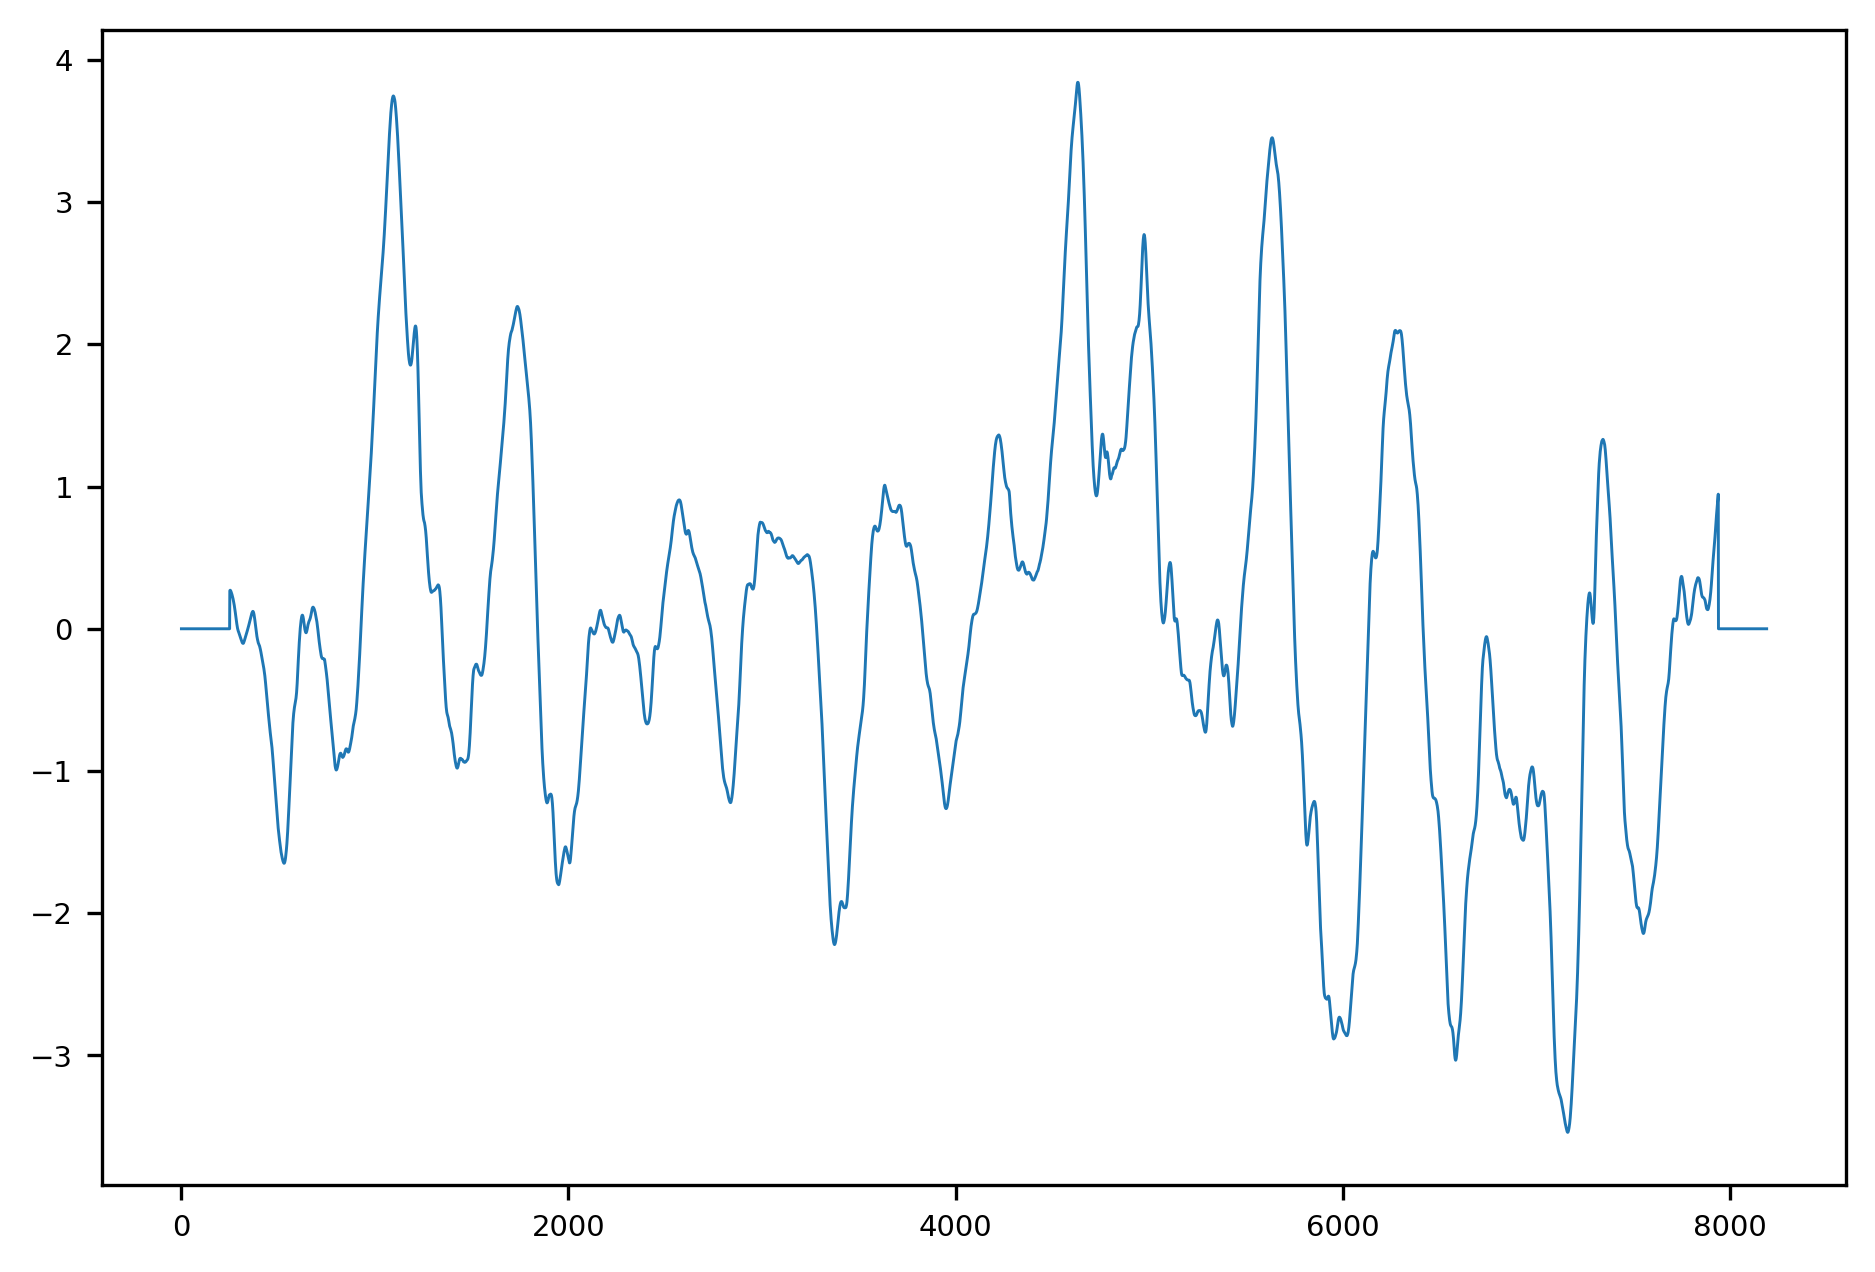

In [721]:
conv = np.convolve(wdf.cumlret, kry, mode='same')
ncut = floor(len(kry)/2)
conv[:ncut] = 0
conv[-ncut:] = 0
ax = plt.plot(conv)

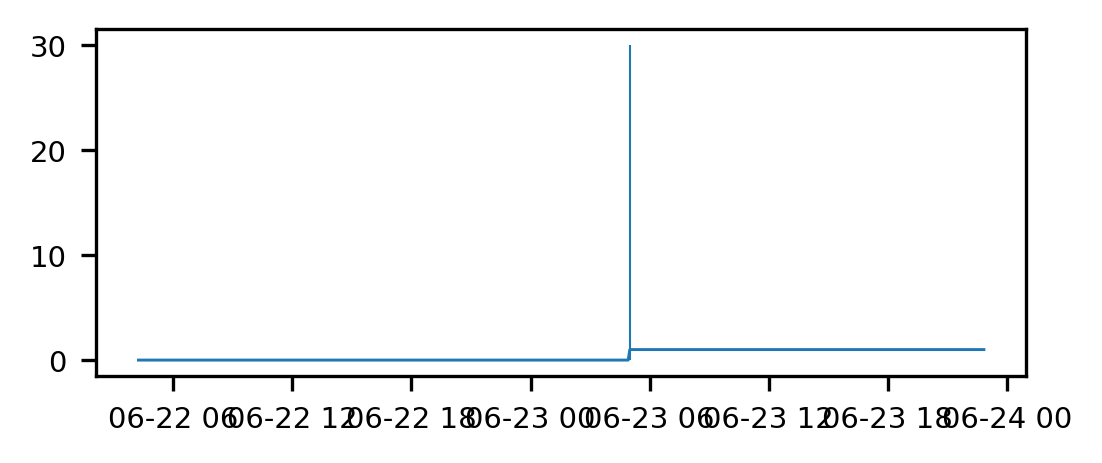

In [261]:
fig = plt.figure(figsize=(4,1.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(g_buy_sig_cum)
ax.vlines(wbsig.index, 0 , 30, lw=0.5)
# ax.plot(xdata2, ydata2, color='tab:orange')



In [230]:
buy_sig

date
2021-06-22 04:15:00     0
2021-06-22 05:30:00     1
2021-06-22 05:35:00     2
2021-06-22 08:00:00     3
2021-06-22 08:05:00     4
2021-06-22 08:10:00     5
2021-06-22 08:15:00     6
2021-06-22 08:20:00     7
2021-06-22 08:25:00     8
2021-06-22 08:35:00     9
2021-06-22 08:40:00    10
2021-06-22 08:45:00    11
2021-06-22 12:00:00    12
2021-06-22 12:05:00    13
2021-06-22 12:10:00    14
2021-06-22 12:20:00    15
2021-06-22 12:25:00    16
2021-06-22 12:35:00    17
2021-06-22 21:40:00    18
2021-06-23 00:05:00    19
2021-06-23 00:10:00    20
2021-06-23 00:15:00    21
2021-06-23 05:00:00    22
2021-06-23 08:55:00    23
2021-06-23 09:00:00    24
2021-06-23 15:10:00    25
2021-06-23 15:15:00    26
2021-06-23 18:00:00    27
2021-06-23 18:10:00    28
2021-06-23 18:15:00    29
2021-06-23 18:20:00    30
2021-06-23 19:55:00    31
2021-06-23 20:00:00    32
dtype: int64